# Quora Insincere Questions Classification

## Capstone Project Two : Springboard Data Science career track

### Notebook by Shalin Gosalia

## Introduction

### 1. The problem 


Quora is a platform that empowers people to learn from each other. On Quora, people can ask questions and connect with others who contribute unique insights and quality answers. A key challenge is to weed out insincere questions -- those founded upon false premises, or that intend to make a statement rather than look for helpful answers.

An existential problem for any major website today is how to handle toxic and divisive content. Quora wants to tackle this problem head-on to keep their platform a place where users can feel safe sharing their knowledge with the world.

### 2. The Data:

The Kaggle hosts the original problem and the dataset in their website as one of their competitions. 

Data files contain
- Training and testing data set where training data set contains quora questionId’s with insincere content marked by value = 1, otherwise 0
- Number of word embeddings along with the dataset that can be used in the models
The file is a matrix of about 376 thousand observations and 7 variables.


For the purpose of this project, I downloaded the data from the Kaggle website. 
- Therafter I performed Data Wrangling, pre-processing and training data development
- After the above steps, the data was condensed into 102K observations which is further broken down into training and testing data set containing 506 features created by count vectorization of 'question_text' column

These are some data wrangling and exploratory analysis from the previous part. For details on how the data was pre-processed and how EDA was performed, see the following notebooks:

https://github.com/shalin4788/Springboard/blob/master/Capstone%20Two/Quora%20Insincere%20Capstone%20Data%20Wrangling.ipynb
https://github.com/shalin4788/Springboard/blob/master/Capstone%20Two/EDA_Quora%20Insincere%20Capstone%20Data.ipynb
https://github.com/shalin4788/Springboard/blob/master/Capstone%20Two/Preprocessing%20and%20Training%20Data%20Development.ipynb

### 3. The questions of interest:

**Objective** - Develop models that identify and flags/ correctly classifies insincere questions and determine classification scores

### 4. Import the necessary libraries and the data:

To start, let's first import all the necessary modules and libraries and read the data set into the Pandas dataframe. 

In [23]:
#os.getcwd()
#os.chdir

import os
import math 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

#ignore warning messages to ensure clean outputs
import warnings
warnings.filterwarnings('ignore')

In [24]:
train_df = pd.read_csv('.\data\FeatureEngineering_tfidf_Train.csv')
test_df = pd.read_csv('.\data\FeatureEngineering_tfidf_Test.csv')

In [25]:
#cat /proc/sys/vm/overcommit_memory

In [26]:
train_df = train_df[train_df.columns.drop('Unnamed: 0')]
train_df.head(2)

,qid,question_final,target,question_length,total_words,avg_word_length_scaled,10,2017,2018,account,...,water,way,websit,white,women,word,work,world,write,year
0,8ee687990fb205a847fa,googl dynam rerout navig,0,24,4,0.113208,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,028751eb08b81ef8a27a,progress democrat believ feder govern run l,1,43,7,0.115903,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
test_df = test_df[test_df.columns.drop('Unnamed: 0')]
test_df.head(2)

,qid,question_final,target,question_length,total_words,avg_word_length_scaled,10,2017,2018,account,...,water,way,websit,white,women,word,work,world,write,year
0,5077e3b60eca75d25cf3,dont peopl ask question new potenti m,0,37,7,0.099730,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,99f0deaffa70fbae599e,colleg better dhaka residenti model colleg raj...,0,68,10,0.128302,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
train_df.dtypes

qid                 object
question_final      object
target               int64
question_length      int64
total_words          int64
                    ...   
word               float64
work               float64
world              float64
write              float64
year               float64
Length: 206, dtype: object

### 5. Feature Selection

These following features are engineered, from any given data column

In [30]:
X = train_df.loc[:, ~train_df.columns.isin(['qid','target','question_length','total_words','avg_word_length_scaled', 'question_final'])]
y = train_df['target']

### 6. Modeling

This is a classification problem, in supervised learning. Here we have used the following classification models:

- Logistic Regression
    - Normal
    - With L2 regularization
- Naive Bayes
- Decision Trees
- Random Forest
- Gradient Boost

Emphasis will be made on Recall score and ROC AUC scores in order to determine which model would perform best
Recall is especially important for this problem since it is important to weed of insincere questions and predicting insincere questions (0) as sincere (1) would be most damaging 

**Note**: insincere questions will be labelled as 1, sincere questions as 0

In [31]:
#Import ML models:
import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree,metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, precision_recall_fscore_support as score
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix, roc_curve, auc

In [8]:
#$ cat /proc/sys/vm/overcommit_memory

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.3, random_state=42)

##### 6a. Logistic Regression

###### Logistic Regression (Normal)

In [52]:
clf = LogisticRegression()
# Fit the model on the trainng data.
clf.fit(X_train, y_train)
# Print the accuracy from the testing data.
print('====Naive Logistic Regression====')
print('Accuracy score:', round(accuracy_score(y_test, clf.predict(X_test)),3))
print('Precision score:', round(precision_score(y_test, clf.predict(X_test)),3))
print('Recall score:', round(recall_score(y_test, clf.predict(X_test)),3))
print('F1 score:', round(f1_score(y_test, clf.predict(X_test),average='weighted'),3))
print('ROC AUC score:', round(roc_auc_score(y_test,clf.predict(X_test)),3))

====Naive Logistic Regression====
Accuracy score: 0.941
Precision score: 0.609
Recall score: 0.137
F1 score: 0.923
ROC AUC score: 0.566


###### Logistic Regression (With L2 Regularization)

In [34]:
C_param_range = [1,10,100, 1000, 10000]

table = pd.DataFrame(columns = ['C_parameter','Accuracy'])
table['C_parameter'] = C_param_range


j = 0
for i in C_param_range:
    # Apply logistic regression model to training data
    Logreg = LogisticRegression(penalty = 'l2', C = i,random_state = 40)
    Logreg.fit(X_train,y_train)
    #Predict using model
    #train_score = Logreg.score(X_train, y_train)
    y_pred_lr = Logreg.predict(X_test)
    # Saving accuracy score in table
    table.iloc[j,1] = accuracy_score(y_test,y_pred_lr)
    j += 1
    
table

,C_parameter,Accuracy
0,1,0.941071
1,10,0.941103
2,100,0.940941
3,1000,0.940941
4,10000,0.940941


====Logistic Regression w/ L2 Regularization====
Accuracy: 0.941
Balanced accuracy: 0.566
Precision score 0.609
Recall score 0.138
F1 score 0.923
ROC AUC score 0.566


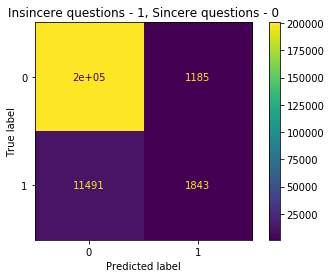

[[200706   1185]
 [ 11491   1843]]


In [53]:
Logreg = LogisticRegression(penalty = 'l2', C = 10,random_state = 42)

Logreg.fit(X_train,y_train)

y_pred_lr = Logreg.predict(X_test)
print('====Logistic Regression w/ L2 Regularization====')
print('Accuracy:', round(metrics.accuracy_score(y_test,y_pred_lr),3))
print('Balanced accuracy:', round(metrics.balanced_accuracy_score(y_test,y_pred_lr),3))
print('Precision score' , round(metrics.precision_score(y_test,y_pred_lr, pos_label = 1),3))
print('Recall score' , round(metrics.recall_score(y_test,y_pred_lr, pos_label = 1),3))
print('F1 score' , round(metrics.f1_score(y_test,y_pred_lr, average='weighted'),3))
print('ROC AUC score' , round(metrics.roc_auc_score(y_test,y_pred_lr),3))
cnf_matrix= confusion_matrix(y_test,y_pred_lr)

_ = plot_confusion_matrix(Logreg, X_test, y_test) 
_ = plt.title('Insincere questions - 1, Sincere questions - 0')
_ = plt.show()

print(cnf_matrix)

#### 6b. Naive Bayes

In [13]:
#def train_KNN(n_neighbors):
#    # Apply K-nearest Neighbor model to training data
#    knn = KNeighborsClassifier(n_neighbors = n)
#    knn.fit(X_train, y_train)
#    train_score = knn.score(X_train, y_train)
#    test_score = knn.score(X_test, y_test)
#    y_pred_knn = knn.predict(X_test)
#    print('Train score: {} / Test score: {} for {} neighbors'.format(train_score, test_score, n))

In [ ]:
#for n in range(1,2):
#    train_KNN(n)

In [28]:
#knn = KNeighborsClassifier(n_neighbors = 2, weights = 'distance', metric='wminkowski', p=2, metric_params=dict(w=2))
#knn.fit(X_train, y_train)

#train_score = knn.score(X_train, y_train)
#test_score = knn.score(X_test, y_test)

# Predict using Knn model
#y_pred_knn = knn.predict(X_test)
#print('====Knn model====')
#print('Train score: {} / Test score: {} for 5 neighbors'.format(train_score, test_score))
#print('Accuracy:', metrics.accuracy_score(y_test,y_pred_knn))
#print('Balanced accuracy:', metrics.balanced_accuracy_score(y_test,y_pred_knn))
#print('Precision score' , metrics.precision_score(y_test,y_pred_knn, pos_label = 1))
#print('Recall score' , metrics.recall_score(y_test,y_pred_knn, pos_label = 1))

In [50]:
nb = GaussianNB()
nb.fit(X_train,y_train)

#Predict using the model:
y_predict_nb=nb.predict(X_test)

#Confusion matrix:

cnf_matrix = confusion_matrix(y_test, y_predict_nb)
print('====Naive Bayes====')
print('Accuracy:', round(metrics.accuracy_score(y_test,y_predict_nb),3))
print('Balanced accuracy:', round(metrics.balanced_accuracy_score(y_test,y_predict_nb),3))
print('Precision score' , round(metrics.precision_score(y_test,y_predict_nb, pos_label = 1),3))
print('Recall score' , round(metrics.recall_score(y_test,y_predict_nb, pos_label = 1),3))
print('F1 score' , round(metrics.f1_score(y_test,y_predict_nb, average='weighted'),3))
print('ROC AUC score' , round(metrics.roc_auc_score(y_test,y_predict_nb),3))

====Naive Bayes====
Accuracy: 0.534
Balanced accuracy: 0.678
Precision score 0.103
Recall score 0.843
F1 score 0.643
ROC AUC score 0.678


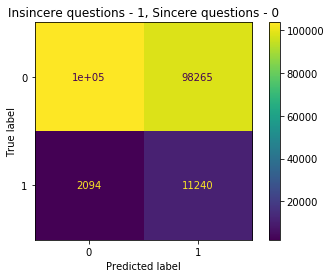

[[103626  98265]
 [  2094  11240]]


In [51]:
cnf_matrix= confusion_matrix(y_test,y_predict_nb)

_ = plot_confusion_matrix(nb, X_test, y_test) 
_ = plt.title('Insincere questions - 1, Sincere questions - 0')
_ = plt.show()

print(cnf_matrix)

#### 6c. Decision Trees

In [40]:
# Declare a variable called gini_model w/ no max_depth and assign it: 
#gini_model_1 = tree.DecisionTreeClassifier(criterion ="gini", random_state = 42)

# Call fit() on gini_model, and pass in X_train and y_train, in that order 
#gini_model_1.fit(X_train, y_train)


# Call predict() on entr_model with X_test passed to it, and assign the result to a variable y_pred 
#y_pred_dt = gini_model_1.predict(X_test)

# Assign y_pred the following: pd.Series(y_pred)
#y_pred_dt = pd.Series(y_pred_dt)

# Check out gini_model
#gini_model_1

Running a 'no max depth' gini model is computationally more expensive and takes a long time to be trained and tested. Hence for the purpose of this project, we will set max depth as 5 and run the Decision Tree Classifier model

In [41]:
# Declare a variable called gini_model, make the max_depth parameter equal to 10 and assign it: 
gini_model_2 = tree.DecisionTreeClassifier(criterion ="gini", max_depth = 10, random_state = 42)

# Call fit() on gini_model, and pass in X_train and y_train, in that order 
gini_model_2.fit(X_train, y_train)

# Call predict() on entr_model with X_test passed to it, and assign the result to a variable y_pred 
y_pred_dt_2 = gini_model_2.predict(X_test)

# Assign y_pred the following: pd.Series(y_pred)
y_pred_dt_2 = pd.Series(y_pred_dt_2)

# Check out gini_model
gini_model_2

DecisionTreeClassifier(max_depth=10, random_state=42)

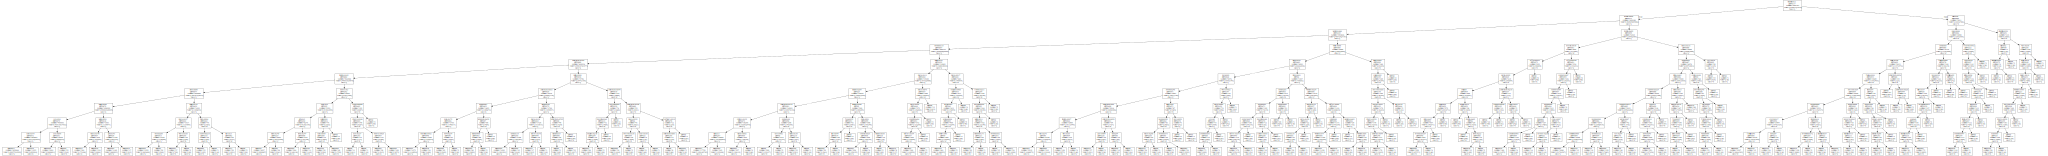

In [42]:
# Now we want to visualize the tree
# We can do so with export_graphviz

import graphviz 
dot_data = tree.export_graphviz(gini_model_2, out_file=None,feature_names=X_train.columns,
                                class_names=str(np.unique(y_train)), 
                                filled=False, rounded=False,
                                special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

In [47]:
print('====Decision Tree: Gini impurity  model - max depth 10====')
print('Accuracy:', round(metrics.accuracy_score(y_test,y_pred_dt_2),3))
print('Balanced accuracy:', round(metrics.balanced_accuracy_score(y_test,y_pred_dt_2),3))
print('Precision score' , round(metrics.precision_score(y_test,y_pred_dt_2, pos_label = 1),3))
print('Recall score' , round(metrics.recall_score(y_test,y_pred_dt_2, pos_label = 1),3))
print('F1 score' , round(metrics.f1_score(y_test,y_pred_dt_2, average='weighted'),3))
print('ROC AUC score' , round(metrics.roc_auc_score(y_test,y_pred_dt_2),3))

====Decision Tree: Gini impurity  model - max depth 10====
Accuracy: 0.942
Balanced accuracy: 0.57
Precision score 0.626
Recall score 0.146
F1 score 0.924
ROC AUC score 0.57


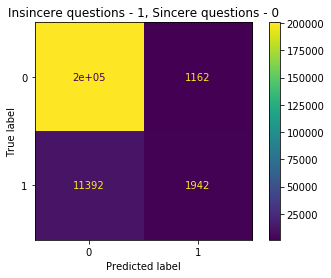

[[200729   1162]
 [ 11392   1942]]


In [48]:
cnf_matrix= confusion_matrix(y_test,y_pred_dt_2)

_ = plot_confusion_matrix(gini_model_2, X_test, y_test) 
_ = plt.title('Insincere questions - 1, Sincere questions - 0')
_ = plt.show()

print(cnf_matrix)

#### 6d. Random Forest

In [46]:
rf = RandomForestClassifier(n_estimators=100, random_state = 1,n_jobs=-1)
model_rf = rf.fit(X_train, y_train)

#Predict test data
y_pred_rf = model_rf.predict(X_test)

print('====Random Forest====')
print('Accuracy score:', round(accuracy_score(y_test, y_pred_rf),3))
print('Precision score:', round(precision_score(y_test,y_pred_rf, pos_label = 1),3))
print('Recall score' , round(metrics.recall_score(y_test,y_pred_dt_2, pos_label = 1),3))
print('f1-score:', round(f1_score(y_test, y_pred_rf, average='weighted'),3))
print('ROC AUC score:', round(roc_auc_score(y_test, y_pred_rf),3))

====Random Forest====
Accuracy score: 0.94
Precision score: 0.553
Recall score 0.146
f1-score: 0.926
ROC AUC score: 0.59


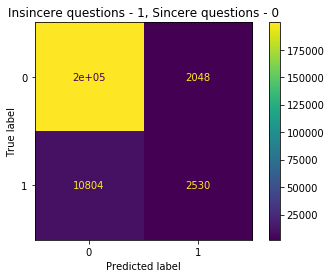

[[199843   2048]
 [ 10804   2530]]


In [49]:
cnf_matrix= confusion_matrix(y_test,y_pred_rf)

_ = plot_confusion_matrix(model_rf, X_test, y_test) 
_ = plt.title('Insincere questions - 1, Sincere questions - 0')
_ = plt.show()

print(cnf_matrix)

#### 6e. Gradient Boosting

In [54]:
def train_GB(n_est, max_features, max_depth):
    gb = GradientBoostingClassifier(n_estimators = n_est, max_features = max_features, max_depth=max_depth)
    gb_model = gb.fit(X_train, y_train)
    y_pred_gb = gb_model.predict(X_test)
    precision, recall, fscore, train_support = score(y_test, y_pred_gb, pos_label=1, average='weighted')
    print('Est: {} / Features: {} / Depth: {} / ---- Precision: {} / Recall: {} / Fscore: {} / Accuracy: {}'.format(
        n_est, max_features, max_depth, round(precision, 3), round(recall, 3), round(fscore,3),
        round((y_pred_gb==y_test).sum()/len(y_pred_gb), 3)))

In [ ]:
for n_est in [150, 300]:
    for max_features in [50, 200]:
        for max_depth in [10, 20]:
            train_GB(n_est, max_features, max_depth)

Est: 150 / Features: 50 / Depth: 10 / ---- Precision: 0.673 / Recall: 0.005 / Accuracy: 0.938
Est: 150 / Features: 50 / Depth: 20 / ---- Precision: 0.67 / Recall: 0.005 / Accuracy: 0.938
Est: 150 / Features: 200 / Depth: 10 / ---- Precision: 0.661 / Recall: 0.005 / Accuracy: 0.938
Est: 150 / Features: 200 / Depth: 20 / ---- Precision: 0.676 / Recall: 0.005 / Accuracy: 0.938
Est: 300 / Features: 50 / Depth: 10 / ---- Precision: 0.667 / Recall: 0.005 / Accuracy: 0.938
Est: 300 / Features: 50 / Depth: 20 / ---- Precision: 0.664 / Recall: 0.005 / Accuracy: 0.938


In [ ]:
#for max_features in [50, 200]:
#    for max_depth in [10,20]:
#        train_GB(200, max_features, max_depth)

In [57]:
learning_rates = [0.5, 1]
for learning_rate in learning_rates:
    gb_updated = GradientBoostingClassifier(n_estimators=100, learning_rate = learning_rate, max_features=50, max_depth = 10, random_state = 0)
    start = time.time()
    gb_model = gb_updated.fit(X_train, y_train)
    end = time.time()
    training_time = (end - start)

    start = time.time()
    y_pred_gb_updated = gb_model.predict(X_test)
    end = time.time()
    pred_time = (end - start)
    
    print('====Gradient Boosting Model====')
    print("Training time:", training_time)
    print("Test prediction time:", pred_time)
    print("Learning rate: ", learning_rate)
    print('Accuracy score:', accuracy_score(y_test, y_pred_gb_updated))
    print('Precision score:', precision_score(y_test,y_pred_gb_updated, pos_label = 1))
    print('Recall score:', recall_score(y_test,y_pred_gb_updated, pos_label = 1))
    print('F1 score:', f1_score(y_test,y_pred_gb_updated, average = 'weighted'))
    print('ROC AUC score:', roc_auc_score(y_test,y_pred_gb_updated))

====Gradient Boosting Model====
Training time: 404.43708181381226
Test prediction time: 2.563971757888794
Learning rate:  0.5
Accuracy score: 0.9381530955976304
Precision score: 0.502195075396068
Recall score: 0.19731513424328784
F1 score: 0.9252829462029396
ROC AUC score: 0.5921986363124448
====Gradient Boosting Model====
Training time: 309.5521910190582
Test prediction time: 1.9527292251586914
Learning rate:  1
Accuracy score: 0.9347798815193402
Precision score: 0.45396201702685
Recall score: 0.2599370031498425
F1 score: 0.9263709036936832
ROC AUC score: 0.6196436232990199


In [58]:
# choose precision score derived at 1 learning rate since that is higher. However, need to ensure that learning rate is not
# very high since lower the learning rate, the score of test data is higher, since there would be less overfitting
f1_score_gb = round(0.9263709036936832, 3)

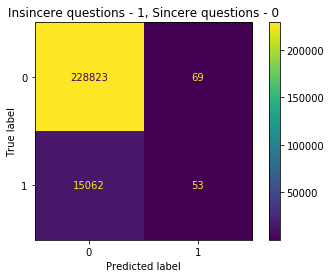

[[228823     69]
 [ 15062     53]]


In [33]:
cnf_matrix= confusion_matrix(y_test,y_pred_gb_updated)

_ = plot_confusion_matrix(gb_updated, X_test, y_test) 
_ = plt.title('Insincere questions - 1, Sincere questions - 0')
_ = plt.show()

print(cnf_matrix)

### 7. Compare Model performances

In [59]:
myLabels = ['Logistic Regression','Logistic Regression w/ L2 Regularization','Naive Bayes', 'Gini Decision Tree', 'Random Forest', 'Gradient Boosting' ]
f1_score = [f1_score(y_test, clf.predict(X_test), average='weighted'), f1_score(y_test,y_pred_lr, average='weighted'), 
            f1_score(y_test,y_predict_nb, average='weighted'), f1_score(y_test,y_pred_dt_2, average='weighted'), 
                  precision_score(y_test,y_pred_rf,average='weighted'), f1_score_gb]
ROC_score = [roc_auc_score(y_test, clf.predict(X_test),average='weighted'), roc_auc_score(y_test, y_pred_lr,average='weighted'),
             roc_auc_score(y_test, y_predict_nb,average='weighted'), roc_auc_score(y_test, y_pred_dt_2,average='weighted'), 
             roc_auc_score(y_test, y_pred_rf,average='weighted'), roc_auc_score(y_test, y_pred_gb_updated,average='weighted')]

score_tab_f1 = pd.DataFrame(list(zip(myLabels, f1_score)), 
               columns =['Algorithm', 'Model f1 score']) 

score_tab_roc = pd.DataFrame(list(zip(myLabels, ROC_score)), 
               columns =['Algorithm', 'ROC AUC score']) 

print(score_tab_f1)
print(score_tab_roc)

                                  Algorithm  Model f1 score
0                       Logistic Regression        0.923162
1  Logistic Regression w/ L2 Regularization        0.923288
2                               Naive Bayes        0.643344
3                        Gini Decision Tree        0.924241
4                             Random Forest        0.924173
5                         Gradient Boosting        0.926000
                                  Algorithm  ROC AUC score
0                       Logistic Regression       0.565527
1  Logistic Regression w/ L2 Regularization       0.566174
2                               Naive Bayes       0.678117
3                        Gini Decision Tree       0.569944
4                             Random Forest       0.589798
5                         Gradient Boosting       0.619644


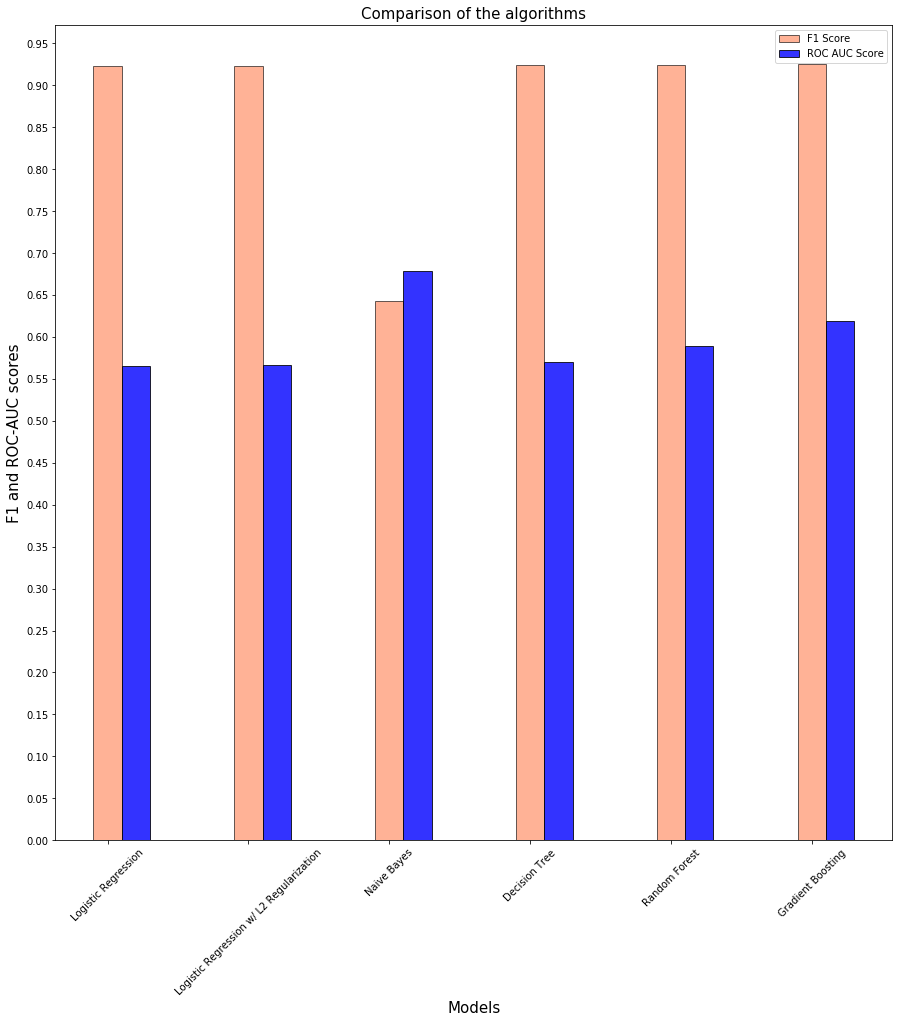

In [66]:
#plotting and comparing ROC-AUC scores:

index=[1,2,3,4,5,6]
index_roc=[1.2, 2.2, 3.2, 4.2, 5.2, 6.2]
plt.figure(figsize=(15,15))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('F1 and ROC-AUC scores',fontsize=15)
plt.title('Comparison of the algorithms',fontsize=15)

plt.yticks(np.arange(0, 1, step=0.05))
plt.xticks([1,2,3,4,5,6], ["Logistic Regression", "Logistic Regression w/ L2 Regularization", "Naive Bayes", "Decision Tree", "Random Forest", "Gradient Boosting"], rotation=45)
_=plt.bar(index, f1_score, label = 'F1 Score',color='coral',alpha=0.6, edgecolor='k',width=0.2)
_=plt.bar(index_roc, ROC_score, color='blue',label = 'ROC AUC Score', alpha=0.8, edgecolor='k',width=0.2)
plt.legend()
plt.savefig("model_comparison.png")
plt.show()

### Conclusion 1

- Since we want to weed out insincere questions from Quora dataset, it is important to have a high f1 score (in this case taken weighted average of positive (insincere questions) and negative (sincere questions) observations) since it is best to have a low false positive rate as well as false negative rate
    - **Reason** - It is important to flag insincere questions and at the same time, not flag sincere questions

- Also ROC AUC score is important to see how well classifier performed

So, I am choosing to plot 'f1 score (weighted)' and 'ROC-AUC' scores to compare models

By that logic, the two best performing models are the Random forest and Gradient Boosting classifiers (see reasoning below)

- Logistic Regression and even Logistic Regression w/ L2 regularization yielded high f1 scores but very low ROC-AUC scores, hence were rejected.
- Naive Bayes classifier's gave an low f1 score but a very high true positive rate and ROC AUC score, since it goes with the assumption that features are independent of one another when conditioned upon class labels which is not true in this case. Hence the model can be deemed not very useful for this use case.
- KNN model was also attempted, but it was taking forever to run considering the size of the dataset, in this case n is close to 1 mn records, hence the computational time is around  O[N log(N)] time - hence the algorithm was stopped midway and rejected.
- After multiple trials, it seems like Decision tree (w/ gini impurity) at max_depth = 10 using gini model, gives a better computational performance and is extremely fast. It has a better ROC AUC score compared to more simpler models like Logistic regression and Naive Bayes classifier, but since decision tree is more susceptible to overfitting and performance erosion as number of trees increase, it is better to not go with this model.
- Random forest, another ensemble Decision tree model results in a better ROC AUC score compared to Decision trees. Though computationally slower and little more complicated to comprehend when more hyperparameter tuning is performed with addition of more features and trees, it is likely to enhance model prediction and scores which could be advantageous for this dataset. 
- Gradient Boosting after performing multiple hyperparameter tuning at just 1 learning rate and low max depth and max_estimators performed pretty well on F1 score and best in terms of ROC AUC scores. 

Conclusion - Based on this, RF and Gradient Boosting are chosen and in the next section, I will try to perform GridSearchCV and hyperparameter tuning on atleast one of the 2 models

### 8.  Applying Grid search CV for hyperparameter Tuning:

##### 8.a Parameter Tuning for Random Forest

- Calculating precision after GridSearch CV 

In [67]:
#https://stats.stackexchange.com/questions/286107/setting-leaf-nodes-minimum-sample-value-for-random-forest-decision-trees

from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(max_features='auto',random_state=1, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"], 
              "max_features": ['auto', 'sqrt', 'log2'],
              "max_depth" : [5,10,20],
              "n_estimators": [100, 200]}

rf_cv_model_2 = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)

rf_cv_2 = rf_cv_model_2.fit(X_train, y_train)

print(rf_cv_2.best_estimator_) 
print(rf_cv_2.best_params_) 
print(rf_cv_2.best_score_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 50.6min finished


RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=200,
                       n_jobs=-1, random_state=1)
{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 200}
0.940130348811508


- Fitting and calculating scores on the Random forest model with optimal hyperparameters

In [70]:
rf_final = RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=200,
                       n_jobs=-1, random_state=1)

rf_final.fit(X_train, y_train)
y_predictions_rf = rf_final.predict(X_test)

- Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

30


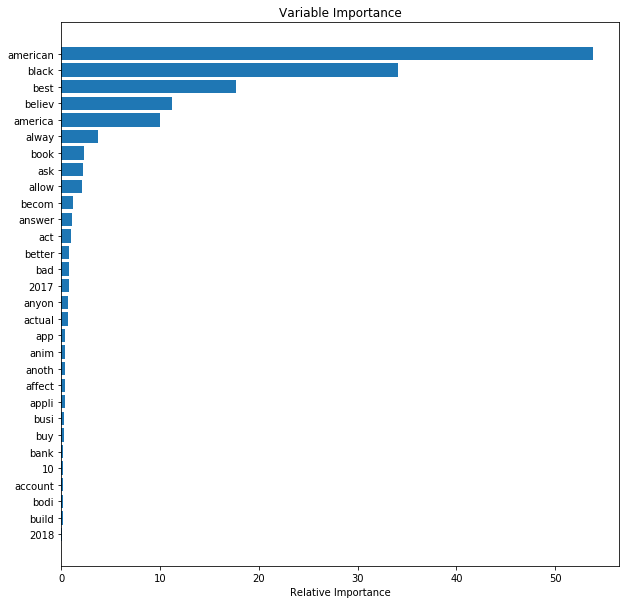

In [98]:
feature_importance = rf_final.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.savefig("Variables with most significant feature Importance.png")
plt.show()

- ROC AUC Curve graph for validation dataset after cross validation

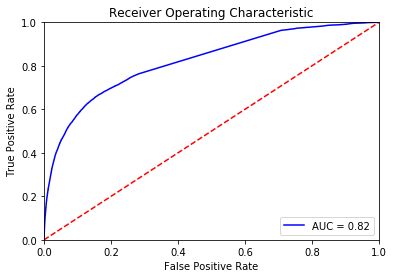

In [99]:
import sklearn.metrics as metrics

y_predictions_rf = rf_final.predict_proba(X_test)[:, 1]
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test, y_predictions_rf)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic - Validation data')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("ROC-AUC score on validation dataset.png")
plt.show()

- F1 weighted score calculation on validation dataset after cross validation

In [93]:
cv = cross_val_score(rf_final, X_test, y_test,scoring='f1_weighted').mean()
print(cv)

0.9169773161596202


##### 8.b Parameter Tuning for Gradient Boosting model

Run if needed

### Conclusion 2

**Final model output**

In above steps
- Cross-Validation procedure was performed under the k-fold CV approach to estimate the skill of the machine learning model on unseen data.
- As a part of this approach, random pair of training and validation data is chosen by splitting the training set iinto k smaller sets, where a model is trained using k-1 of the folds as training data and the model is validated on the remaining part.
- It was observed that there was a great improvement in ROC AUC score when hyperparameter turning was done on Random Forest model. However, the mean of f1-weighted score after hyperparameter tuning and cross validation was almost around the same range as before
- Hence for this use case, Random forest model was deemed best amongst other models in terms of precision and ROC-AUC scores 
    - ROC AUC score - 0.82
    - f1 score (weighted) - 0.917

In [118]:
joblib.dump(rf_final,  'models/RandomForestModel.joblib')

['models/RandomForestModel.joblib']

### 9. Actual test data prediction

In [119]:
import joblib

loaded_rf = joblib.load('models/RandomForestModel.joblib')

In [101]:
X_actual_test = test_df.loc[:, ~test_df.columns.isin(['qid','target','question_length','total_words','avg_word_length_scaled', 'question_final'])]
y_actual_test = test_df['target']

In [120]:
# Fit the final training dataset
loaded_rf.fit(X_actual_test, y_actual_test)

#Perform prediction
y_test_predictions_rf = loaded_rf.predict(X_actual_test)

- ROC AUC Curve graph on actual test dataset after cross validation

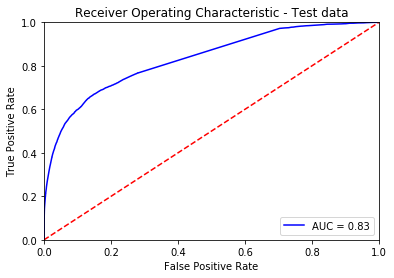

In [121]:
import sklearn.metrics as metrics

y_test_predictions_rf = loaded_rf.predict_proba(X_actual_test)[:, 1]
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_actual_test, y_test_predictions_rf)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic - Test data')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("ROC-AUC score on unseen test dataset.png")
plt.show()

- F1 weighted score calculation on actual test dataset after cross validation

In [122]:
cv = cross_val_score(loaded_rf, X_actual_test, y_actual_test,scoring='f1_weighted').mean()
print(cv)

0.9160418377058519


### Conclusion 3

**Prediction on unseen test data**

- The scores below are pretty good and very close to the scores obtained on validation dataset after performing cross validation, which is conclusive that model selection was good and the classification done using Random forest model is a good indication of a significantly accurate prediction on unseen test data set 
    - ROC AUC score - 0.83
    - f1 score (weighted) - 0.916

### Future Score

**Future Scope**
- Hyperparameter tuning can be performed on Gradient boosting models but limiting scope of this notebook to only tuning RF classifier model
- Also, the number of max features aka categorical features chosen for this modeling step was only 200 due to CPU constraints causing overcommit memory issues
- In a real world, with the usage of sophisticated processors and availability of more resources, model performances can be enhanced further by choosing 500- 1000 max features in the feature engineering step without getting rid of important features and performing hyperparameter tuning on multiple parameters as a baseline, but that couldn't be covered in the scope of this project